- Load Kalman Data
- Load Video
- Align Timestamps\
- align "0" distance from ground plane on kalman\
- For each frame in video, let POS = closest kalman timestep\
- project points from "depth" where depth is render of ground plane - to test this, produce video of ground plane from phone orientation\
- rotate pointcloud and render from above
- use SIFT to transform it into relative position of first image



In [85]:
import os
import cv2
import numpy as np
import cupy as cp
from ultralytics import YOLO
import matplotlib.pyplot as plt
import sys
from PIL import Image
from importlib import reload
import pandas as pd
import plotly.express as px
import gdown
import zipfile
from filterpy.kalman import KalmanFilter

sys.path.insert(1, '..')
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"

In [86]:
files = {
    'walk_to_malachowski' : 'https://drive.google.com/file/d/1EejwRl80fnWIlh9l_YjYTrjQb3d7mMSR/view?usp=drive_link',
    'walk_down_parking_lot' : 'https://drive.google.com/file/d/1RtRjmR7ggn5DgyxNK6mGkihZY-g9NyCq/view?usp=drive_link',
    'malachowski_chamomile' : 'https://drive.google.com/file/d/1V28HPGOMnI-l-GiAFGB5xzt0YajLtwMU/view?usp=drive_link',
    'malachowski_chamomile_2' : 'https://drive.google.com/file/d/1JD9SI-bM44BPeG2frwaznO2Fq97BAmUM/view?usp=drive_link',
    'first_test_walk' : 'https://drive.google.com/file/d/1u7FCFc4uaZscHvZ6wH9wU2pb_Mz9djPF/view?usp=drive_link'
}

def convert_to_direct_download(gdrive_link):
    start = gdrive_link.find('/d/') + 3
    end = gdrive_link.find('/view', start)
    file_id = gdrive_link[start:end]

    direct_download_url = f'https://drive.google.com/uc?id={file_id}&export=download'

    return direct_download_url

# Load Data

In [87]:
# @title Selected File
selected = "walk_to_malachowski" # @param ["malachowski_chamomile", "malachowski_chamomile_2", "walk_to_malachowski", "first_test_walk", "walk_down_parking_lot"]

url = convert_to_direct_download(files[selected])
gdown.download(url, "of.zip")
with zipfile.ZipFile("./of.zip", 'r') as zip_ref:
    zip_ref.extractall("../Data/")

Downloading...
From (original): https://drive.google.com/uc?id=1EejwRl80fnWIlh9l_YjYTrjQb3d7mMSR&export=download
From (redirected): https://drive.google.com/uc?id=1EejwRl80fnWIlh9l_YjYTrjQb3d7mMSR&export=download&confirm=t&uuid=c9849c7c-12ca-4c98-ad5e-4c79c5a235a8
To: c:\Users\c1a55\Documents\Roborouter\data\walk_to_malachowski\of.zip
100%|██████████| 536M/536M [00:08<00:00, 63.2MB/s]


In [88]:
%cd ../data/
%cd $selected

c:\Users\c1a55\Documents\Roborouter\data\data
c:\Users\c1a55\Documents\Roborouter\data\data\walk_to_malachowski


In [89]:
AccelerometerDF = pd.read_csv('Accelerometer.csv')
print("🔴Accelerometer:")
print(AccelerometerDF.head(1))
#east   //in m/s^2
#north  //in m/s^2
#up     //in m/s^2

BarometerDF = pd.read_csv('Barometer.csv')
print("🔵Barometer:")
print(BarometerDF.head(1))
#relativeAltitude //in meters

LocationDF = pd.read_csv('Location.csv')
print("🟢Location:")
print(LocationDF.head(1))
#up                 //(in meters)
#speedAccuracy      //in m/s
#bearingAccuracy    //in degrees
#east               //(in meters)
#bearing            //direction of travel since last data point (might be redundant to fuse?)
#horizontalAccuracy //which is in meters
#verticalAccuracy   //also in meters
#north              //(in meters)
#speed              //velocity along the bearing provided

#To be used for synchronization
MicrophoneDF = pd.read_csv('Microphone.csv')
#print("Microphone:")
#print(MicrophoneDF.head(1))
#dBFS

#Prefused = best guess. Smoothing welcomed.
OrientationDF = pd.read_csv('Orientation.csv')
print("🟠Orientation:")
print(OrientationDF.head(1))
#yaw
#qx
#qz
#roll
#qw
#qy
#pitch

🔴Accelerometer:
                  time  seconds_elapsed         z         y         x
0  1707585936836849400         0.120849 -1.105513  0.109932 -0.172708
🔵Barometer:
                  time  seconds_elapsed  relativeAltitude     pressure
0  1707585936256298000        -0.459702               0.0  1016.647186
🟢Location:
                  time  seconds_elapsed  altitude  speedAccuracy  \
0  1707585908244470000        -28.47153  6.276319       1.207736   

   bearingAccuracy   latitude  altitudeAboveMeanSeaLevel  bearing  \
0             -1.0  29.644654                  35.686319     -1.0   

   horizontalAccuracy  verticalAccuracy  longitude     speed  
0            4.758735          3.343498 -82.345984  0.132651  
🟠Orientation:
                  time  seconds_elapsed       yaw        qx        qz  \
0  1707585936836849400         0.120849 -0.543345 -0.028643  0.269779   

       roll        qw        qy     pitch  
0 -0.096052 -0.960761  0.057768  0.086314  


(145, 12)
(132, 4)
(14492, 5)


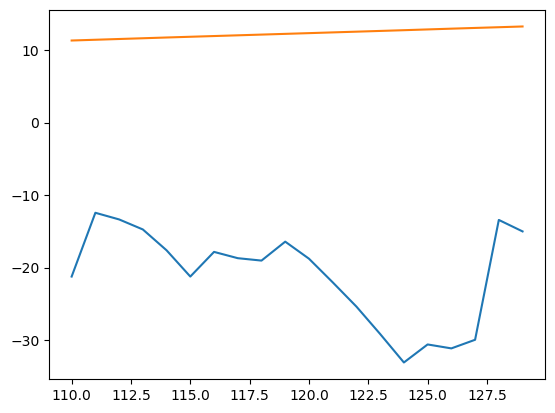

In [90]:
# Sync microphone tinmings with video playback:
videoPlaybackClapTimestamp = 3 + 24.5/30
#30fps, clap spotted at ~24/25 frames after 3 seconds elapsed, so clap two in malachowski occurs at video time of (3 + 24.5/30)

plt.plot((MicrophoneDF[['dBFS', 'seconds_elapsed']][110:130]))
#looks like the clap occurs at around index 123 to 126
#print(MicrophoneDF['seconds_elapsed'][110:130])

#indeed, seems all our stuff starts around 12.5 seconds elapsed
secondsElapsedSync = 12.5

LocationDF = LocationDF[LocationDF['seconds_elapsed'] >= 12.5]
BarometerDF = BarometerDF[BarometerDF['seconds_elapsed'] >= 12.5]
AccelerometerDF = AccelerometerDF[AccelerometerDF['seconds_elapsed'] >= 12.5]
OrientationDF = OrientationDF[OrientationDF['seconds_elapsed'] >= 12.5]

print(LocationDF.shape)
print(BarometerDF.shape)
print(AccelerometerDF.shape)


In [91]:
from scipy.spatial.transform import Rotation as R
pi = np.pi


ax, ay, az = 30, 0, 30  # Example acceleration vector
qx, qy, qz, qw = -0.07, -0.4, -0.06, 0.9  # Example quaternion (no rotation)


def convert_xyz_acceleration_to_NEU(ax, ay, az, qx, qy, qz, qw):
  Rquat = R.from_quat([qx, qy, qz, qw])
  rotation_matrix = Rquat.as_matrix()
  inv = rotation_matrix.T
  result = inv @ [ax, ay, az]
  return result

convert_xyz_acceleration_to_NEU(ax, ay, az, qx, qy, qz, qw)
#definitely correct as fuck.

array([       42.3,      2.6367,     -1.9285])

## Convert accelerations using orientation dataframe

In [92]:
#Preprocessing the accelerations into ENU accelerations using the phone rotation:
def process_row(row, orient_df):
    ax, ay, az = row['x'], row['y'], row['z']
    ori_row = orient_df.loc[row.name]  # Assumes same index in orient_df as in accel_df

    qw, qx, qy, qz = ori_row['qw'], ori_row['qx'], ori_row['qy'], ori_row['qz']
    north, east, up = convert_xyz_acceleration_to_NEU(ax, ay, az, qx, qy, qz, qw)

    return pd.Series([north, east, up], index=['north', 'east', 'up'])

def convert_accelerations(accel_df, orient_df):
    result_df = accel_df.copy()
    result_df.rename(columns={'x': 'north', 'y': 'east', 'z': 'up'}, inplace=True)
    transformations = accel_df.apply(process_row, axis=1, args=(orient_df,))  # Apply row-wise
    result_df[['north', 'east', 'up']] = transformations  # Update the result DataFrame
    return result_df



print(AccelerometerDF.head(3))
AccelerometerENUDF=convert_accelerations(AccelerometerDF, OrientationDF)
print(AccelerometerENUDF.head(3))

                     time  seconds_elapsed         z         y         x
1235  1707585949218205400        12.502205 -0.134372  0.073516 -0.056918
1236  1707585949228230400        12.512230 -0.087288  0.058662 -0.098186
1237  1707585949238256400        12.522256 -0.085665  0.085258 -0.079662


  4%|▍         | 24.1M/536M [00:15<00:14, 36.4MB/s]

                     time  seconds_elapsed        up      east     north
1235  1707585949218205400        12.502205 -0.130516  0.013886 -0.097328
1236  1707585949228230400        12.512230 -0.078243 -0.016237 -0.119646
1237  1707585949238256400        12.522256 -0.080218  0.016169 -0.119403


## Just visualizing the integrated acceleration data.
Its not great, but it does represent the course

In [93]:
def integrate_acceleration_to_position(df):
    # Reset index to ensure consistent positional indexing
    df = df.reset_index(drop=True)
    
    # Calculate the differences in time to get dt
    dt = df['seconds_elapsed'].diff().fillna(0)  # Using fillna(0) for the first value
    
    # Initialize columns for velocity and position
    for axis in ['up', 'east', 'north']:
        df[f'velocity_{axis}'] = 0
        df[f'position_{axis}'] = 0
    
    # Calculate velocity and position using the trapezoidal rule for integration
    for i in range(1, len(df)):
        for axis in ['up', 'east', 'north']:
            # Integrate acceleration to find velocity
            df.loc[i, f'velocity_{axis}'] = (
                df.loc[i-1, f'velocity_{axis}'] + 
                0.5 * (df.loc[i, axis] + df.loc[i-1, axis]) * dt.iloc[i]
            )
            
            # Integrate velocity to find position
            df.loc[i, f'position_{axis}'] = (
                df.loc[i-1, f'position_{axis}'] + 
                0.5 * (df.loc[i, f'velocity_{axis}'] + df.loc[i-1, f'velocity_{axis}']) * dt.iloc[i]
            )
    
    # Select only the position columns for the result
    position_columns = [col for col in df.columns if 'position' in col]
    return df[position_columns]

int_location_df = integrate_acceleration_to_position(AccelerometerENUDF)

fig = px.line_3d(
    int_location_df,
    x=int_location_df['position_north'],
    y=int_location_df['position_east'],
    z=int_location_df['position_up']
)
fig.layout.scene.aspectmode='data'
fig.show()

In [94]:
import pymap3d as pm
lat0 = LocationDF.iloc[0]['latitude']  # deg
lon0 = LocationDF.iloc[0]['longitude']  # deg
h0 = LocationDF.iloc[0]['altitude']     # meters

def convert_to_enu(row):
    # Conversion using scalar reference points
    (east, north, up) = pm.geodetic2enu(row['latitude'], row['longitude'], row['altitude'], lat0, lon0, h0)
    return pd.Series([east, north, up], index=['east', 'north', 'up'])

# Apply the function to each row and create new columns
LocationENUDF = LocationDF.copy()
LocationENUDF[['east', 'north', 'up']] = LocationDF.apply(convert_to_enu, axis=1)

# Show first few results
print(LocationENUDF[['east', 'north', 'up']].head(3))

# Visualization using Plotly Express
fig = px.line_3d(LocationENUDF, x='north', y='east', z='up', title='3D Trajectory in ENU Coordinates')
fig.layout.scene.aspectmode='data'
fig.show()


        east     north        up
14  0.000000  0.000000  0.000000
15 -0.119395  0.027304 -0.117257
16 -0.119395  0.027304 -0.117257


# Perform Kalman Filtering

In [95]:
def preprocess_location_data_with_accuracy(df):
    # Make sure your DataFrame is sorted by time or seconds_elapsed before applying this function
    df = df.sort_values(by='seconds_elapsed').reset_index(drop=True)

    # Initialize columns for velocity components in the east and north directions
    df['velocity_east'] = 0.0
    df['velocity_north'] = 0.0
    df['velocity_error_east'] = 0.0
    df['velocity_error_north'] = 0.0

    # Calculate the velocity components and their errors
    for i in range(1, len(df)):
        # Calculate time difference in seconds
        dt = df.at[i, 'seconds_elapsed'] - df.at[i-1, 'seconds_elapsed']
        
        # Convert speed and bearing to velocity components in east and north directions
        speed = df.at[i, 'speed']
        bearing = np.radians(df.at[i, 'bearing'])  # Convert bearing to radians for calculation
        df.at[i, 'velocity_east'] = speed * np.sin(bearing)
        df.at[i, 'velocity_north'] = speed * np.cos(bearing)
        
        # Bearing and speed accuracy
        bearing_accuracy = np.radians(df.at[i, 'bearingAccuracy'])  # Convert bearing accuracy to radians
        speed_accuracy = df.at[i, 'speedAccuracy']

        # Calculate velocity error due to bearing inaccuracy
        bearing_error_east = abs(speed * np.cos(bearing) * bearing_accuracy)
        bearing_error_north = abs(speed * np.sin(bearing) * bearing_accuracy)

        # Calculate velocity error due to speed inaccuracy
        speed_error_east = abs(speed_accuracy * np.sin(bearing))
        speed_error_north = abs(speed_accuracy * np.cos(bearing))

        # Combine errors for total velocity uncertainty in each direction
        df.at[i, 'velocity_error_east'] = np.sqrt(bearing_error_east**2 + speed_error_east**2)
        df.at[i, 'velocity_error_north'] = np.sqrt(bearing_error_north**2 + speed_error_north**2)

    return df

# Example usage:
# Assuming LocationENUDF is your DataFrame
LocationENUDF = preprocess_location_data_with_accuracy(LocationENUDF)

In [100]:
#AccelerometerENUDF
#BarometerDF



kf = KalmanFilter(dim_x=9, dim_z=3)  # 9 for pos, vel, acc; adjust dim_z based on measurements

kf.x = (np.zeros(9)) #Initialize to 0 velocity, acceleration, position
kf.P = np.eye(9) * 10  # Initialize with a large uncertainty in initial state

kf.F = np.eye(9) #will be updated per below
def update_F(sensor_type, dt):
    F = np.eye(9)  # Start with identity matrix and modify only necessary parts
    
    if sensor_type == 'Accelerometer':
        # Accelerometer affects acceleration, which affects velocity and position
        F[3:6, 6:9] = np.eye(3) * dt  # Update velocity with acceleration
        F[0:3, 3:6] = np.eye(3) * dt  # Update position with velocity
        F[0:3, 6:9] = 0.5 * np.eye(3) * dt**2  # Update position with acceleration
    elif sensor_type == 'GPS':
        # F = np.zeros((9, 9))
        # F[0:3, 0:3] = np.eye(3) #gps only updates position
        F = np.eye(9)  # Start with identity matrix and modify only necessary parts
        F[0:3, 3:6] = np.eye(3) * dt  # Update position with velocity

    kf.F = F

kf.Q = np.eye(9)
kf.Q[0,0] = kf.Q[1,1] = kf.Q[2,2] = 1 #Position noise
kf.Q[3,3] = kf.Q[4,4] = kf.Q[5,5] = 1 #Velocity noise
kf.Q[6,6] = kf.Q[7,7] = kf.Q[8,8] = 1 #Acceleration noise
print(kf.Q)

# Placeholder for measurement matrix (H) and measurement noise covariance (R)
kf.H = np.eye(3, 9)  
kf.R = np.eye(3)     

def gps_measurement_matrix():
    # Assuming we measure position directly
    H = np.zeros((5, 9))
    H[0, 0] = 1  # Measure east position
    H[1, 1] = 1  # Measure north position
    H[2, 2] = 1  # Measure up position
    H[3, 3] = 1  # Measure east velocity
    H[4, 4] = 1  # Measure north velocity
    return H

# Accelerometer measurements
def accel_measurement_matrix():
    # Assuming we measure the second derivative of position (acceleration)
    H = np.zeros((3, 9))
    H[0, 6] = 1  # Acceleration east
    H[1, 7] = 1  # Acceleration north
    H[2, 8] = 1  # Acceleration up
    return H


LocationENUDF['sensor_type'] = 'GPS'
AccelerometerENUDF['sensor_type'] = 'Accelerometer'

merged_df = pd.concat([LocationENUDF, AccelerometerENUDF], ignore_index=True)
merged_df.sort_values('seconds_elapsed', inplace=True)
merged_df.reset_index(drop=True, inplace=True)

last_time = {'GPS': 0, 'Accelerometer': 0}
dict = {'seconds_elapsed':[], 'east':[], 'north':[], 'up':[]}
outputCoords = pd.DataFrame(dict)
for index, row in merged_df.iterrows():
    sensor_type = row['sensor_type']
    current_time = row['seconds_elapsed']
    
    # Calculate dt using the last timestamp for the current sensor type
    if last_time[sensor_type] == 0:  # If it's the first measurement of this type
        dt = 0  # There's no previous measurement to compare to
    else:
        dt = current_time - last_time[sensor_type]
    
    # Update the last_time for the current sensor type
    last_time[sensor_type] = current_time

    # Update the state transition matrix for the new dt
    update_F(sensor_type, dt)
    kf.predict()
    if row['sensor_type'] == 'Accelerometer':
        kf.dim_z = 3 
        kf.H = accel_measurement_matrix()
        kf.R = np.diag([(row['east']*.01)**2,(row['north']*.01)**2, (row['up']*.01)**2])  # Assume constant accelerometer noise; adjust as necessary
        measurement = np.array([row['east'], row['north'], row['up']])
        kf.update(measurement)
    elif row['sensor_type'] == 'GPS':
        kf.dim_z = 5 
        kf.H = gps_measurement_matrix()
        kf.R = np.diag([row['horizontalAccuracy']**2, row['horizontalAccuracy']**2, row['verticalAccuracy']**2, row['velocity_error_east']**2*0.1, row['velocity_error_north']**2*0.1])*10
        measurement = np.array([row['east'], row['north'], row['up'], row['velocity_east'], row['velocity_north']])
        kf.update(measurement)

    # Save filter state to outputCoords
    outputCoords.loc[len(outputCoords.index)] = [current_time , *kf.x[0:3]]

# Add a 'source' column to each DataFrame to distinguish them in the plot
LocationENUDF['source'] = 'GPS'
outputCoords['source'] = 'Kalman Filter'

# Combine the two DataFrames
combined_df = pd.concat([LocationENUDF.rename(columns={'east': 'Y', 'north': 'X', 'up': 'Z'}),
                         outputCoords.rename(columns={'east': 'Y', 'north': 'X', 'up': 'Z'})])

# Plot using Plotly Express
fig = px.line_3d(combined_df, x='X', y='Y', z='Z', color='source')
fig.layout.scene.aspectmode='data'
fig.show()

[[          1           0           0           0           0           0           0           0           0]
 [          0           1           0           0           0           0           0           0           0]
 [          0           0           1           0           0           0           0           0           0]
 [          0           0           0           1           0           0           0           0           0]
 [          0           0           0           0           1           0           0           0           0]
 [          0           0           0           0           0           1           0           0           0]
 [          0           0           0           0           0           0           1           0           0]
 [          0           0           0           0           0           0           0           1           0]
 [          0           0           0           0           0           0           0           0           1]]


In [104]:
display(outputCoords.head(-1)) #east north up source
print(outputCoords.shape)
print(OrientationDF.shape)
display(OrientationDF.head(-1))

,seconds_elapsed,east,north,up,source
0,12.502205,0.000000e+00,0.000000,0.000000,Kalman Filter
1,12.512230,6.978118e-07,-0.000005,-0.000007,Kalman Filter
2,12.522256,1.277486e-06,-0.000021,-0.000024,Kalman Filter
3,12.532281,1.853627e-06,-0.000048,-0.000049,Kalman Filter
4,12.542308,5.603968e-06,-0.000087,-0.000082,Kalman Filter
...,...,...,...,...,...
14631,157.753922,-1.455634e+02,-13.037463,2.151931,Kalman Filter
14632,157.763949,-1.455643e+02,-13.037921,2.152790,Kalman Filter
14633,157.773977,-1.455652e+02,-13.038396,2.153724,Kalman Filter
14634,157.784005,-1.455660e+02,-13.038881,2.154685,Kalman Filter


(14637, 5)
(14492, 9)


,time,seconds_elapsed,yaw,qx,qz,roll,qw,qy,pitch
1235,1707585949218205400,12.502205,-0.597521,-0.042520,0.295476,-0.066682,-0.953200,0.047923,0.109599
1236,1707585949228230400,12.512230,-0.597437,-0.042530,0.295433,-0.066562,-0.953216,0.047861,0.109579
1237,1707585949238256400,12.522256,-0.597320,-0.042559,0.295373,-0.066374,-0.953237,0.047768,0.109575
1238,1707585949248281600,12.532281,-0.597136,-0.042617,0.295282,-0.066185,-0.953267,0.047682,0.109630
1239,1707585949258307600,12.542308,-0.596993,-0.042656,0.295210,-0.066033,-0.953291,0.047610,0.109657
...,...,...,...,...,...,...,...,...,...
15721,1707586094469922000,157.753922,-2.342837,0.193352,-0.874011,0.208199,0.398322,-0.200146,0.528100
15722,1707586094479949000,157.763949,-2.343678,0.193267,-0.874210,0.208317,0.397968,-0.200068,0.527797
15723,1707586094489977000,157.773977,-2.343536,0.193275,-0.874226,0.208475,0.398047,-0.199829,0.527364
15724,1707586094500005000,157.784005,-2.343331,0.193139,-0.874270,0.208315,0.398123,-0.199618,0.526865
